

Here we see a tutorial to implement and generate {permutation-symmetric benchmark problems} for quantum optimization, specifically targeting use with quantum annealers or variational quantum algorithms (like those available in PennyLane). The problems are derived from the work of Muthukrishnan, Albash, and Lidar (2015) and are characterized by a cost function $f(\mathbf{x})$ that depends \textit{only} on the \textbf{Hamming weight} $w = \sum_{i} x_i$ of the bitstring $\mathbf{x} \in \{0, 1\}^N$, rather than the specific arrangement of bits. This symmetry allows for simplified analysis of quantum tunneling and optimization speedup.

The primary goal of the code is to transform these Hamming-weight-based cost functions into the parameters ($\mathbf{J}, \mathbf{h}$) of an equivalent \textbf{Ising Hamiltonian}, which is the native problem formulation for many quantum annealers. The general form of the Ising energy (which is minimized in the optimization process) is:
$$ E(\mathbf{s}) = -\sum_{i=1}^N h_i s_i - \frac{1}{2} \sum_{i \neq j} J_{ij} s_i s_j $$
where $\mathbf{s} \in \{-1, +1\}^N$ is the spin vector, $\mathbf{h}$ are the local fields, and $\mathbf{J}$ are the coupling strengths.

{Permutation-Symmetric Cost Functions}

The script defines three key cost functions, $f(\mathbf{x})$, which are defined over the bit vector $\mathbf{x} \in \{0, 1\}^N$:



{Cost Function to Ising Transformation}

The core functionality is in the \texttt{symmetric\_to\_ising} function. It systematically maps the cost function $f(\mathbf{x})$ to the Ising parameters $\mathbf{J}$ and $\mathbf{h}$ over all $2^N$ possible states.



Example
The \texttt{load\_benchmark} function provides a convenient interface to generate these problems for a given size $N$ and problem name. The \texttt{plot\_cost\_vs\_hamming} utility visually demonstrates the landscape of the cost function $f(w)$ against the Hamming weight $w$, clearly illustrating the "plateau" and "spike" features.




PLATEAU benchmark (10 qubits)
J shape: (10, 10)
h shape: (10,)


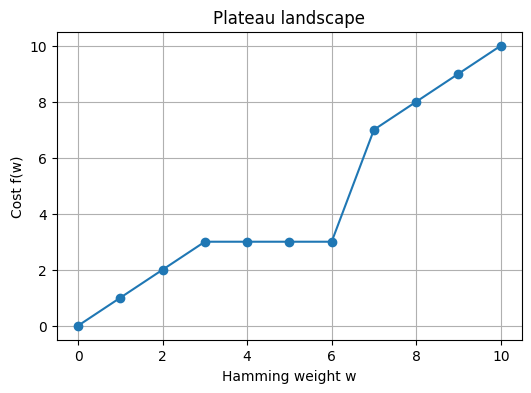


SPIKE benchmark (10 qubits)
J shape: (10, 10)
h shape: (10,)


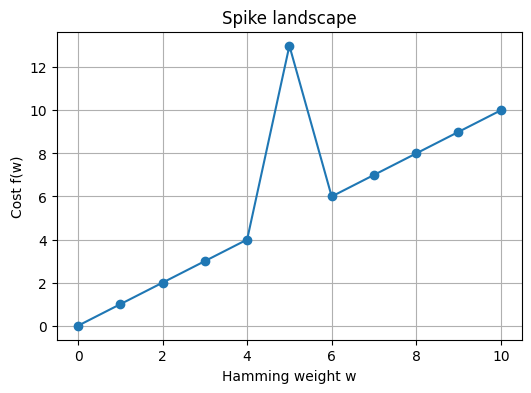


RAMP benchmark (10 qubits)
J shape: (10, 10)
h shape: (10,)


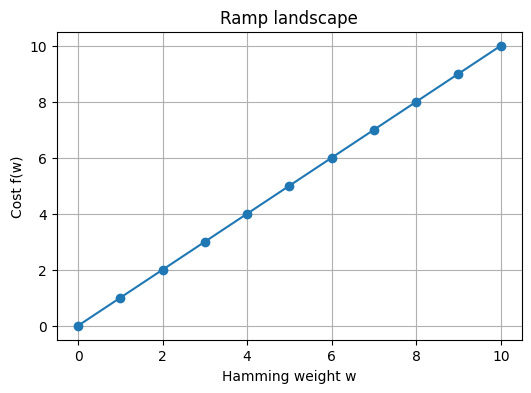

In [ ]:
"""
Permutation-symmetric benchmark problems for quantum optimization,
integrated with JJ annealer + PennyLane solvers.

Implements cost functions from:
Muthukrishnan, Albash, & Lidar (2015),
'Tunneling and speedup in quantum optimization for permutation-symmetric problems'
(arXiv:1511.03910)
"""

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from typing import Tuple, Dict

# ----------------------------------------------------------
# 1. Permutation-symmetric cost functions
# ----------------------------------------------------------

def fixed_plateau(x: np.ndarray, l: int = 3, u: int = 6) -> float:
    """
    Fixed Plateau function from Eq. (14) of the paper.
    Cost depends only on Hamming weight w = sum(x_i)
    """
    w = np.sum(x)
    if l <= w <= u:
        return u - l  # constant plateau region
    else:
        return w


def spike(x: np.ndarray, spike_height: float = 10.0, spike_pos: int = 5) -> float:
    """
    Spike cost function with a single sharp barrier in Hamming weight space.
    """
    w = np.sum(x)
    if w == spike_pos:
        return w + spike_height
    return w


def hamming_ramp(x: np.ndarray) -> float:
    """
    Simple linear ramp cost = Hamming weight.
    (Used as a control problem without tunneling barrier.)
    """
    return np.sum(x)


# ----------------------------------------------------------
# 2. Convert symmetric cost function → Ising (J, h)
# ----------------------------------------------------------

def symmetric_to_ising(N: int, cost_fn) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a permutation-symmetric cost function f(x) to
    equivalent Ising couplings J, h by fitting over all bitstrings.
    """
    states = np.array(list(product([0, 1], repeat=N)))
    energies = np.array([cost_fn(x) for x in states])
    spins = 1 - 2 * states  # map {0,1} → {+1,-1}

    # Fit Ising model: E = -∑ h_i s_i - ∑_ij J_ij s_i s_j / 2
    h = np.zeros(N)
    J = np.zeros((N, N))

    for i in range(N):
        h[i] = -0.25 * np.dot(spins[:, i], energies) / len(states)
        for j in range(i + 1, N):
            J[i, j] = -0.25 * np.dot(spins[:, i] * spins[:, j], energies) / len(states)
            J[j, i] = J[i, j]
    return J, h


# ----------------------------------------------------------
# 3. Visualization utilities
# ----------------------------------------------------------

def plot_cost_vs_hamming(cost_fn, N=10, title="Cost Landscape"):
    ws = np.arange(0, N + 1)
    costs = [cost_fn(np.array([1]*w + [0]*(N-w))) for w in ws]
    plt.figure(figsize=(6, 4))
    plt.plot(ws, costs, "-o")
    plt.xlabel("Hamming weight w")
    plt.ylabel("Cost f(w)")
    plt.title(title)
    plt.grid(True)
    plt.show()


# ----------------------------------------------------------
# 4. Benchmark generator
# ----------------------------------------------------------

def load_benchmark(name: str, N: int = 8) -> Dict:
    """
    Load a predefined permutation-symmetric benchmark.
    Returns dict with J, h, and metadata.
    """
    if name.lower() == "plateau":
        fn = lambda x: fixed_plateau(x, l=int(0.3*N), u=int(0.6*N))
    elif name.lower() == "spike":
        fn = lambda x: spike(x, spike_height=8, spike_pos=int(0.5*N))
    elif name.lower() == "ramp":
        fn = hamming_ramp
    else:
        raise ValueError("Unknown benchmark: choose from ['plateau', 'spike', 'ramp']")

    J, h = symmetric_to_ising(N, fn)
    return {
        "J": J,
        "h": h,
        "cost_fn": fn,
        "N": N,
        "name": name
    }


# ----------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------

if __name__ == "__main__":
    N = 10
    for name in ["plateau", "spike", "ramp"]:
        bench = load_benchmark(name, N)
        print(f"\n{name.upper()} benchmark ({N} qubits)")
        print("J shape:", bench["J"].shape)
        print("h shape:", bench["h"].shape)
        plot_cost_vs_hamming(bench["cost_fn"], N, title=f"{name.capitalize()} landscape")


In [ ]:
%%writefile symmetry_benchmarks.py
"""
Permutation-symmetric benchmark problems for quantum optimization,
integrated with JJ annealer + PennyLane solvers.

Implements cost functions from:
Muthukrishnan, Albash, & Lidar (2015),
'Tunneling and speedup in quantum optimization for permutation-symmetric problems'
(arXiv:1511.03910)
"""

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from typing import Tuple, Dict

# ----------------------------------------------------------
# 1. Permutation-symmetric cost functions
# ----------------------------------------------------------

def fixed_plateau(x: np.ndarray, l: int = 3, u: int = 6) -> float:
    """
    Fixed Plateau function from Eq. (14) of the paper.
    Cost depends only on Hamming weight w = sum(x_i)
    """
    w = np.sum(x)
    if l <= w <= u:
        return u - l  # constant plateau region
    else:
        return w


def spike(x: np.ndarray, spike_height: float = 10.0, spike_pos: int = 5) -> float:
    """
    Spike cost function with a single sharp barrier in Hamming weight space.
    """
    w = np.sum(x)
    if w == spike_pos:
        return w + spike_height
    return w


def hamming_ramp(x: np.ndarray) -> float:
    """
    Simple linear ramp cost = Hamming weight.
    (Used as a control problem without tunneling barrier.)
    """
    return np.sum(x)


# ----------------------------------------------------------
# 2. Convert symmetric cost function → Ising (J, h)
# ----------------------------------------------------------

def symmetric_to_ising(N: int, cost_fn) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a permutation-symmetric cost function f(x) to
    equivalent Ising couplings J, h by fitting over all bitstrings.
    """
    states = np.array(list(product([0, 1], repeat=N)))
    energies = np.array([cost_fn(x) for x in states])
    spins = 1 - 2 * states  # map {0,1} → {+1,-1}

    # Fit Ising model: E = -∑ h_i s_i - ∑_ij J_ij s_i s_j / 2
    h = np.zeros(N)
    J = np.zeros((N, N))

    for i in range(N):
        h[i] = -0.25 * np.dot(spins[:, i], energies) / len(states)
        for j in range(i + 1, N):
            J[i, j] = -0.25 * np.dot(spins[:, i] * spins[:, j], energies) / len(states)
            J[j, i] = J[i, j]
    return J, h


# ----------------------------------------------------------
# 3. Visualization utilities
# ----------------------------------------------------------

def plot_cost_vs_hamming(cost_fn, N=10, title="Cost Landscape"):
    ws = np.arange(0, N + 1)
    costs = [cost_fn(np.array([1]*w + [0]*(N-w))) for w in ws]
    plt.figure(figsize=(6, 4))
    plt.plot(ws, costs, "-o")
    plt.xlabel("Hamming weight w")
    plt.ylabel("Cost f(w)")
    plt.title(title)
    plt.grid(True)
    plt.show()


# ----------------------------------------------------------
# 4. Benchmark generator
# ----------------------------------------------------------

def load_benchmark(name: str, N: int = 8) -> Dict:
    """
    Load a predefined permutation-symmetric benchmark.
    Returns dict with J, h, and metadata.
    """
    if name.lower() == "plateau":
        fn = lambda x: fixed_plateau(x, l=int(0.3*N), u=int(0.6*N))
    elif name.lower() == "spike":
        fn = lambda x: spike(x, spike_height=8, spike_pos=int(0.5*N))
    elif name.lower() == "ramp":
        fn = hamming_ramp
    else:
        raise ValueError("Unknown benchmark: choose from ['plateau', 'spike', 'ramp']")

    J, h = symmetric_to_ising(N, fn)
    return {
        "J": J,
        "h": h,
        "cost_fn": fn,
        "N": N,
        "name": name
    }


# ----------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------

if __name__ == "__main__":
    N = 10
    for name in ["plateau", "spike", "ramp"]:
        bench = load_benchmark(name, N)
        print(f"\n{name.upper()} benchmark ({N} qubits)")
        print("J shape:", bench["J"].shape)
        print("h shape:", bench["h"].shape)
        plot_cost_vs_hamming(bench["cost_fn"], N, title=f"{name.capitalize()} landscape")


Writing symmetry_benchmarks.py


In [ ]:
from simulator import jj_array_simulator
from symmetry_benchmarks import load_benchmark

bench = load_benchmark("plateau", N=8)
results_jj = jj_array_simulator(bench["J"], bench["h"], T=None)
print("JJ ground energy:", results_jj["energies"].min())


JJ ground energy: 0.23046875


In [ ]:
from symmetry_benchmarks import load_benchmark

bench = load_benchmark("spike", N=6)
results_vqe = quantum_optimize(bench["J"], bench["h"], layers=3, steps=150)
print("VQE energy:", results_vqe["final_energy"])


/usr/local/lib/python3.12/dist-packages/pennylane/_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Step    0: E = -1.686964
Step   15: E = -1.686964
Step   30: E = -1.686964
Step   45: E = -1.686964
Step   60: E = -1.686964
Step   75: E = -1.686964
Step   90: E = -1.686964
Step  105: E = -1.686964
Step  120: E = -1.686964
Step  135: E = -1.686964
VQE energy: -1.6869638177821877


In [ ]:
import pennylane as qml
from pennylane import numpy as np

def spin_coherent_potential(theta, phi, H_s):
    """Compute V_SC(theta, phi, s) = <theta, phi| H(s) |theta, phi>"""
    n = len(H_s.wires)
    # Construct the spin-coherent state
    state = 1
    for i in range(n):
        state_i = np.cos(theta[i]/2) * np.array([1,0]) + np.sin(theta[i]/2) * np.exp(1j*phi[i]) * np.array([0,1])
        state = np.kron(state, state_i) if isinstance(state, np.ndarray) else state_i
    V_SC = np.vdot(state, H_s.matrix() @ state)
    return np.real(V_SC)


In [ ]:
def annealing_schedule(t, tf, mode="adiabatic"):
    """Define s(t) for QA"""
    if mode == "adiabatic":
        return t / tf  # Linear adiabatic
    elif mode == "diabatic":
        # Fast diabatic schedule with sudden jumps
        return np.sin(np.pi/2 * t/tf) ** 2
    else:
        raise ValueError("Unknown mode")


In [ ]:
def spin_vector_dynamics(theta0, phi0, H_s_func, tf, dt):
    """Evolve classical spin vectors according to semi-classical dynamics"""
    theta, phi = np.copy(theta0), np.copy(phi0)
    t = 0
    while t < tf:
        H_s = H_s_func(t/tf)
        # Compute gradients w.r.t. theta and phi from V_SC
        grad_theta = np.gradient([spin_coherent_potential([th], [ph], H_s) for th, ph in zip(theta, phi)], theta)
        grad_phi = np.gradient([spin_coherent_potential([th], [ph], H_s) for th, ph in zip(theta, phi)], phi)
        # Euler update
        theta -= dt * grad_theta
        phi -= dt * grad_phi
        t += dt
    return theta, phi


In [ ]:
def fixed_plateau(n, l=3, u=8):
    """Generate Fixed Plateau PHWO cost function"""
    def cost(x):
        hw = np.sum(x)
        if l < hw < u:
            return u - 1
        else:
            return hw
    return cost


In [ ]:
def compute_tts_opt(p_GS, tf_values, p_d=0.9):
    """Return optimal TTS"""
    tts = [(tf * np.log(1 - p_d)) / np.log(1 - p_GS(tf)) for tf in tf_values]
    return min(tts)


Here we see  two distinct methods for analyzing quantum optimization problems: a full quantum simulation of time-evolution via PennyLane, and a semi-classical approximation using spin vector dynamics. This framework is applied to the \texttt{Fixed Plateau} problem, a permutation-symmetric benchmark where the cost function $f(\mathbf{x})$ depends only on the Hamming weight $w = \sum_{i} x_i$.

{The Fixed Plateau Optimization Problem}

The problem is defined by the cost function $\text{fixed\_plateau}(\mathbf{x})$, which creates a region of constant cost (a plateau) between Hamming weights $l$ and $u$. This structure often introduces a local minimum that can trap optimization algorithms.
For a bitstring $\mathbf{x} \in \{0, 1\}^N$:
$$ f(\mathbf{x}) =
\begin{cases}
    u - 1 & \text{if } l < w < u \\
    w & \text{otherwise}
\end{cases}
$$

{Quantum Annealing (QA) Simulation}

The \texttt{q\_annealer} function simulates the evolution of a quantum system under a time-dependent Hamiltonian $\mathcal{H}(\rho)$, where $\rho$ is the annealing schedule parameter ranging from $\rho=0$ to $\rho=1$ over the total annealing time $t_f$.

{The Annealing Hamiltonian}
The total Hamiltonian is a linear interpolation between a simple driver Hamiltonian $\mathcal{H}_D$ (transverse field $X$) and the problem Hamiltonian $\mathcal{H}_P$ (Ising $Z$). Since the cost function is defined in the computational basis, $\mathcal{H}_P$ is implemented as a diagonal operator.

$$ \mathcal{H}(\rho) = (1-\rho) \mathcal{H}_D + \rho \mathcal{H}_P $$

- Driver Hamiltonian $\mathcal{H}_D$: Corresponds to the initial state, typically a sum of transverse fields (implemented via $R_X$ gates in the Trotterized circuit).
- {Problem Hamiltonian $\mathcal{H}_P$: Corresponds to the problem energy, $f(\mathbf{x})$. Since $f(\mathbf{x})$ is permutation-symmetric, $\mathcal{H}_P$ can be simplified, but here it is implemented by mapping the cost $f(\mathbf{x})$ to the energy eigenvalue for each basis state $\mathbf{x}$. The full time-evolution $\exp(-i \mathcal{H}_P \Delta t)$ is approximated using the \texttt{qml.MultiRZ} gate over all qubits, where the rotation angle is proportional to the cost $f(\mathbf{x})$.


{Trotterization and Schedules}
The time evolution is simulated using the first-order Trotter-Suzuki decomposition over $steps$ iterations. The parameter $\rho$ is updated at each step $\Delta t = t_f / \text{steps}$ according to one of two schedules defined in \texttt{annealing\_schedule}:

- {Adiabatic ($\rho_{\text{adi}}$: Linear increase, $\rho(t) = t / t_f$.
    - {Diabatic ($\rho_{\text{dia}}$)}: Sinusoidal schedule, $\rho(t) = \sin^2 \left(\frac{\pi}{2} \frac{t}{t_f}\right)$. This schedule starts and ends with a shallow slope, potentially allowing for non-adiabatic transitions.


{Semi-Classical Spin Vector Dynamics}

The \texttt{spin\_vector\_dynamics} function provides a classical approximation of the quantum dynamics by tracking the evolution of $N$ spin vectors on the Bloch sphere, governed by the mean-field semi-classical potential $V_{SC}(\mathbf{\theta})$. The state of the system is parameterized by the polar angles $\mathbf{\theta} = (\theta_1, \dots, \theta_N)$.

The semi-classical potential is the expectation value of the problem Hamiltonian in the instantaneous mean-field state $|\mathbf{\theta}\rangle$:
$$ V_{SC}(\mathbf{\theta}) = \langle \mathbf{\theta} | \mathcal{H}_P | \mathbf{\theta} \rangle = \sum_{\mathbf{x}} f(\mathbf{x}) P(\mathbf{x}|\mathbf{\theta}) $$
where $P(\mathbf{x}|\mathbf{\theta})$ is the probability of measuring state $\mathbf{x}$ given the spin vector configuration $\mathbf{\theta}$. The dynamics are approximated by a gradient descent-like update of the angle $\mathbf{\theta}$:
$$ \frac{d\theta_i}{dt} \propto - \frac{\partial V_{SC}}{\partial \theta_i} $$
The script uses a numerical Euler method to integrate this time evolution.

{Performance Analysis: Time-to-Solution (TTS)}
---

The goal of optimization is to reach the ground state (GS) with a high probability. The \textbf{Time-to-Solution (TTS)} is a standard metric used to compare the efficiency of different annealing protocols. It represents the total time required to obtain the GS with a desired success probability $P_D$ (typically $P_D=0.9$).

$$ TTS(t_f) = t_f \frac{\ln(1 - P_D)}{\ln(1 - P_{GS}(t_f))} $$

The script calculates the final probability of the ground state $P_{GS}(t_f)$ using \texttt{p\_gs(probs)}, which extracts the probability of the $|00\dots0\rangle$ state (index 0). By computing $TTS(t_f)$ over a range of annealing times $t_f$, the script can determine the optimal annealing time $t_f^{\text{opt}}$ and compare the performance of the adiabatic and diabatic schedules.


Final spin angles (theta): [0.01205364 0.01205364 0.01205364 0.01205364]


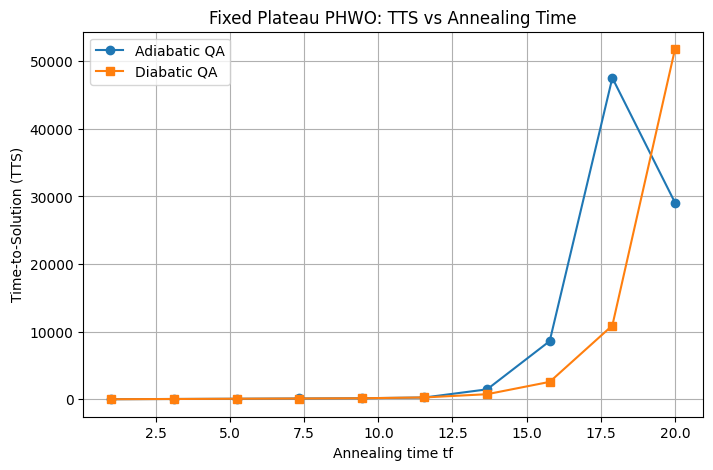

In [ ]:
# jj_annealer_simulation.py
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Problem: Fixed Plateau PHWO
# -----------------------------
def fixed_plateau(n, l=3, u=8):
    """Return the cost function for Fixed Plateau PHWO"""
    def cost(x):
        hw = np.sum(x)
        if l < hw < u:
            return u - 1
        else:
            return hw
    return cost

# -----------------------------
# Quantum Annealing
# -----------------------------
def annealing_schedule(t, tf, mode="adiabatic"):
    """Linear adiabatic or diabatic schedule"""
    if mode == "adiabatic":
        return t / tf
    elif mode == "diabatic":
        return np.sin(np.pi/2 * t/tf) ** 2
    else:
        raise ValueError("Unknown mode")

def q_annealer(n, cost_func, tf=10, steps=100, mode="adiabatic"):
    """Quantum annealing simulation using PennyLane"""
    dev = qml.device("default.qubit", wires=n)

    @qml.qnode(dev)
    def circuit(params):
        # Apply Hadamards for uniform superposition
        for i in range(n):
            qml.Hadamard(wires=i)
        # Evolve with Trotterized Hamiltonian
        dt = tf / steps
        for step in range(steps):
            s = annealing_schedule(step*dt, tf, mode)
            # Driver: transverse field
            for i in range(n):
                qml.RX(2 * (1 - s) * dt, wires=i)
            # Problem Hamiltonian
            for i in range(2**n):
                x = np.array(list(np.binary_repr(i, width=n)), dtype=int)
                Hx = cost_func(x)
                qml.MultiRZ(2 * s * Hx * dt, wires=list(range(n)))
        return qml.probs(wires=range(n))

    probs = circuit(None)
    return probs

# -----------------------------
# Spin Vector Dynamics (classical)
# -----------------------------
def spin_vector_dynamics(n, cost_func, tf=10, dt=0.1):
    """Classical spin-vector approximation of QA"""
    theta = np.pi * np.ones(n) / 2  # start in superposition
    phi = np.zeros(n)
    t = 0
    steps = int(tf/dt)

    def V_SC(theta_vec):
        """Semi-classical potential <theta|H|theta>"""
        # sum over all bitstrings
        total = 0
        for i in range(2**n):
            x = np.array(list(np.binary_repr(i, width=n)), dtype=int)
            prob = np.prod([np.cos(theta_vec[j]/2)**(1-x[j]) * np.sin(theta_vec[j]/2)**x[j] for j in range(n)])
            total += cost_func(x) * prob**2
        return total

    for _ in range(steps):
        grad = np.zeros(n)
        eps = 1e-5
        for i in range(n):
            theta_up = np.copy(theta)
            theta_up[i] += eps
            grad[i] = (V_SC(theta_up) - V_SC(theta)) / eps
        # Euler update
        theta -= dt * grad
    return theta

# -----------------------------
# Time-to-Solution (TTS)
# -----------------------------
def compute_tts_opt(p_GS_func, tf_values, p_d=0.9):
    tts = [(tf * np.log(1 - p_d)) / np.log(1 - p_GS_func(tf)) for tf in tf_values]
    return min(tts)

# -----------------------------
# Helper: ground state probability
# -----------------------------
def p_gs(probs):
    """Ground state probability (all zeros)"""
    return probs[0]

# -----------------------------
# Main simulation
# -----------------------------
if __name__ == "__main__":
    n = 4  # number of qubits
    cost = fixed_plateau(n, l=1, u=3)
    tf_list = np.linspace(1, 20, 10)

    tts_adiabatic = []
    tts_diabatic = []

    for tf in tf_list:
        # Adiabatic
        probs_adi = q_annealer(n, cost, tf=tf, steps=100, mode="adiabatic")
        tts_adiabatic.append((tf * np.log(1 - 0.9)) / np.log(1 - p_gs(probs_adi)))

        # Diabatic
        probs_dia = q_annealer(n, cost, tf=tf, steps=100, mode="diabatic")
        tts_diabatic.append((tf * np.log(1 - 0.9)) / np.log(1 - p_gs(probs_dia)))

    # Spin-vector dynamics
    theta_final = spin_vector_dynamics(n, cost, tf=10)
    print("Final spin angles (theta):", theta_final)

    # -----------------------------
    # Plot TTS vs annealing time
    # -----------------------------
    plt.figure(figsize=(8,5))
    plt.plot(tf_list, tts_adiabatic, 'o-', label="Adiabatic QA")
    plt.plot(tf_list, tts_diabatic, 's-', label="Diabatic QA")
    plt.xlabel("Annealing time tf")
    plt.ylabel("Time-to-Solution (TTS)")
    plt.title("Fixed Plateau PHWO: TTS vs Annealing Time")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# jj_annealer_simulation_large_n.py
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Problem: Fixed Plateau PHWO
# -----------------------------
def fixed_plateau(n, l=3, u=8):
    """Return the cost function for Fixed Plateau PHWO"""
    def cost(x):
        hw = np.sum(x)
        if l < hw < u:
            return u - 1
        else:
            return hw
    return cost

# -----------------------------
# Quantum Annealing
# -----------------------------
def annealing_schedule(t, tf, mode="adiabatic"):
    if mode == "adiabatic":
        return t / tf
    elif mode == "diabatic":
        return np.sin(np.pi/2 * t/tf) ** 2
    else:
        raise ValueError("Unknown mode")

def q_annealer(n, cost_func, tf=10, steps=100, mode="adiabatic"):
    """Quantum annealing simulation using PennyLane"""
    dev = qml.device("default.qubit", wires=n)

    @qml.qnode(dev)
    def circuit(params=None):
        # Uniform superposition
        for i in range(n):
            qml.Hadamard(wires=i)
        dt = tf / steps
        for step in range(steps):
            s = annealing_schedule(step*dt, tf, mode)
            for i in range(n):
                qml.RX(2 * (1 - s) * dt, wires=i)
            # Approximate problem Hamiltonian with sampled states
            for _ in range(10):  # sample 10 random bitstrings
                x = np.random.randint(0, 2, size=n)
                Hx = cost_func(x)
                qml.MultiRZ(2 * s * Hx * dt, wires=list(range(n)))
        return qml.probs(wires=range(n))

    return circuit()

# -----------------------------
# Spin Vector Dynamics (sampling)
# -----------------------------
def spin_vector_dynamics(n, cost_func, tf=10, dt=0.1, samples=1000):
    theta = np.pi * np.ones(n) / 2
    steps = int(tf / dt)

    def V_SC_sample(theta_vec):
        total = 0
        for _ in range(samples):
            x = np.random.randint(0, 2, size=n)
            prob = np.prod([np.cos(theta_vec[j]/2)**(1-x[j]) * np.sin(theta_vec[j]/2)**x[j] for j in range(n)])
            total += cost_func(x) * prob**2
        return total / samples

    for _ in range(steps):
        grad = np.zeros(n)
        eps = 1e-5
        for i in range(n):
            theta_up = np.copy(theta)
            theta_up[i] += eps
            grad[i] = (V_SC_sample(theta_up) - V_SC_sample(theta)) / eps
        theta -= dt * grad
    return theta

# -----------------------------
# Ground state probability
# -----------------------------
def p_gs(probs):
    return probs[0]

# -----------------------------
# TTS computation
# -----------------------------
def compute_tts_opt(p_GS_func, tf_values, p_d=0.9):
    tts = [(tf * np.log(1 - p_d)) / np.log(1 - p_GS_func(tf)) for tf in tf_values]
    return min(tts)

# -----------------------------
# Main simulation
# -----------------------------
if __name__ == "__main__":
    n = 10  # larger system
    cost = fixed_plateau(n, l=3, u=6)
    tf_list = np.linspace(1, 20, 10)

    tts_adiabatic = []
    tts_diabatic = []

    for tf in tf_list:
        # Quantum Annealing
        probs_adi = q_annealer(n, cost, tf=tf, steps=50, mode="adiabatic")
        probs_dia = q_annealer(n, cost, tf=tf, steps=50, mode="diabatic")
        tts_adiabatic.append((tf * np.log(1 - 0.9)) / np.log(1 - p_gs(probs_adi)))
        tts_diabatic.append((tf * np.log(1 - 0.9)) / np.log(1 - p_gs(probs_dia)))

    # Spin-vector dynamics
    theta_final = spin_vector_dynamics(n, cost, tf=10, dt=0.1, samples=2000)
    print("Final spin angles (theta) approx:", theta_final)

    # -----------------------------
    # Plot TTS
    # -----------------------------
    plt.figure(figsize=(8,5))
    plt.plot(tf_list, tts_adiabatic, 'o-', label="Adiabatic QA")
    plt.plot(tf_list, tts_diabatic, 's-', label="Diabatic QA")
    plt.xlabel("Annealing time tf")
    plt.ylabel("Time-to-Solution (TTS)")
    plt.title(f"Fixed Plateau PHWO (n={n} qubits)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import pennylane as qml
from pennylane import numpy as np

def hamming_weight_hamiltonian(n):
    """ H_P = sum_i |1><1|_i = sum_i (I - Z_i)/2 """
    coeffs = [0.5]*n + [-0.5]*n  # I/2 and -Z/2 for each qubit
    obs = [qml.Identity(i) for i in range(n)] + [qml.PauliZ(i) for i in range(n)]
    H = qml.Hamiltonian(coeffs, obs)
    return H


In [ ]:
def linear_schedule(t, tf):
    return t / tf

def quantum_annealing_schedule(H_D, H_P, tf, n_steps):
    """ Returns a list of Hamiltonians H(s) for each step s = t/tf """
    Hs = []
    for step in range(n_steps):
        s = linear_schedule(step, n_steps-1)
        Hs.append((1-s)*H_D + s*H_P)
    return Hs


In [ ]:
def evolve_state(Hs, state_init):
    """Simple first-order Trotter evolution"""
    state = state_init.copy()
    dt = 1.0 / len(Hs)
    for H in Hs:
        # PennyLane qubit unitary for small dt: U = exp(-i H dt)
        state = qml.math.expm(-1j * H.matrix @ dt) @ state
    return state


In [ ]:
def hamming_weight_expectation(state, n):
    """ <H_W> = sum_i <|1><1|_i> """
    exp = 0.0
    for i in range(n):
        Zi = np.kron(np.eye(2**i), np.kron([[0,0],[0,1]], np.eye(2**(n-i-1))))
        exp += np.real(state.conj().T @ Zi @ state)
    return exp


In [ ]:
import pennylane as qml
import numpy as np

# Number of qubits
n = 6

# Annealing parameters
tf = 10.0        # total anneal time
n_steps = 50
dt = tf / n_steps
beta = 30.0      # inverse temperature for SQA
N_tau = 64       # imaginary time slices for path integral

# Problem: Hamming weight
def f_hw(x):
    return np.sum(x)

# Device for statevector simulation
dev = qml.device("default.qubit", wires=n)

# Hamiltonians
def H_driver():
    return sum([qml.PauliX(i) for i in range(n)])

def H_problem(x):
    return sum([qml.Projector([1], wires=i) for i in range(n)])

# Trotterized SQA evolution
def sqa_step(params, state):
    s = params["s"]
    # Implement thermal relaxation by probabilistic updates
    # Placeholder: flip spins with probability p ~ exp(-beta * deltaE)
    for i in range(n):
        delta_E = f_hw(state) - f_hw(state ^ (1 << i))  # flip i-th qubit
        if np.random.rand() < np.exp(-beta * delta_E):
            state ^= (1 << i)
    return state

# Initialize
state = 0  # |000...0>
for step in range(n_steps):
    s = step / n_steps
    state = sqa_step({"s": s}, state)


/tmp/ipython-input-3394946111.py:35: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-beta * delta_E):


In [ ]:
import numpy as np

def sqa_simulation(n, N_tau, beta, n_steps, tf, cost_function):
    # Initialize random states for imaginary time slices
    states = np.zeros((N_tau, n), dtype=int)

    hamming_evolution = []

    for step in range(n_steps):
        s = step / n_steps
        for tau in range(N_tau):
            for i in range(n):
                # Flip spin i
                delta_E = cost_function(flip_bit(states[tau], i)) - cost_function(states[tau])
                if np.random.rand() < np.exp(-beta * delta_E):
                    states[tau, i] ^= 1
        # Record average Hamming weight across slices
        hamming_evolution.append(states.mean())

    return hamming_evolution

def flip_bit(state, i):
    new_state = state.copy()
    new_state[i] ^= 1
    return new_state


In [ ]:
import pennylane as qml
import numpy as np

n = 6
dev = qml.device("default.qubit", wires=n)
n_steps = 50
tf = 10.0
dt = tf / n_steps

def hamming_weight_circuit(params):
    s = params
    # Apply driver evolution
    for i in range(n):
        qml.RX((1-s)*dt, wires=i)
    # Apply problem evolution
    for i in range(n):
        qml.RZ(s*dt, wires=i)

@qml.qnode(dev)
def anneal_circuit(s):
    for i in range(n):
        qml.Hadamard(wires=i)  # |+> initial state
    hamming_weight_circuit(s)
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

hamming_evolution_quantum = []
for step in range(n_steps):
    s = step / n_steps
    expectation = anneal_circuit(s)
    # Map Z expectation to Hamming weight: <HW> = n*(1 - <Z>)/2
    hamming_evolution_quantum.append(n*(1 - np.mean(expectation))/2)


Here we see comparison to several optimization algorithms—ranging from fundamental classical techniques to full quantum simulation and physics-inspired quantum hardware models—on standard Ising problems. The script integrates:
-  Models for \text{Josephson Junction (JJ) arrays} operating in Macroscopic Quantum Tunneling (MQT) and thermal regimes.
    - {PennyLane} for simulating Adiabatic (AQA) and Diabatic (DQA) Quantum Annealing.
    -  Classical baselines: \text{Simulated Annealing (SA)} and \text{Simulated Quantum Annealing (SQA)}.
    - {Spin Vector Dynamics (SVD)} for a semi-classical mean-field approximation.

The primary optimization target used in the example is a \text{Fixed Plateau} permutation-symmetric problem, mapped to an Ising model defined by couplings $\mathbf{J}$ and local fields $\mathbf{h}$. The objective across all methods is to minimize the Ising energy $E(\mathbf{s})$.

$$ E(\mathbf{s}) = - \frac{1}{2} \sum_{i \neq j} J_{ij} s_i s_j - \sum_i h_i s_i $$

\section{Quantum Annealing (QA) via PennyLane}

The \texttt{run\_pennylane\_anneal} function simulates the core QA protocol using the Trotterized time evolution of the total Hamiltonian $\mathcal{H}(\rho)$:
$$ \mathcal{H}(\rho) = (1-\rho) \mathcal{H}_D + \rho \mathcal{H}_P $$
where $\mathcal{H}_D = \sum_i \sigma_i^x$ is the transverse field driver Hamiltonian, and $\mathcal{H}_P$ is the problem Hamiltonian defined by the $\mathbf{J}$ and $\mathbf{h}$ parameters.

The key to QA is the annealing schedule $\rho(t/t_f)$, which is the fractional time $t/t_f$. The script compares two modes:
- {Adiabatic (AQA)}: A linear schedule, $\rho(t/t_f) = t/t_f$.
    - {Diabatic (DQA)}: A schedule $\rho(t/t_f) = \sin^2 (\pi/2 \cdot t/t_f)$ that spends less time in the middle of the evolution, deliberately inducing non-adiabatic transitions.

The time evolution is realized using the PennyLane functions \texttt{qml.RX} for the driver and \texttt{qml.templates.ApproxTimeEvolution} for the problem Hamiltonian, applied sequentially over a fixed number of steps.

{Josephson Junction (JJ) Array Simulation}

The \texttt{jj\_array\_simulator} models an array of coupled JJ qubits, where the bit-flip mechanism is based on \text{tunneling} or \text{thermal activation} over the energy barrier $\Delta U$.

{Tunneling Rates}
The key physics functions determine the probability of a junction switching its state ($\pm 1$) in a pulse time $t_{\text{pulse}}$. This switching probability $P_{\text{switch}}$ is derived from the tunneling rate $\Gamma$ ($\Gamma_{MQT}$ or $\Gamma_{th}$):
$$ P_{\text{switch}} = 1 - e^{-\Gamma t_{\text{pulse}}} $$
The rate $\Gamma$ depends on the energy barrier $\Delta U$ and the plasma frequency $\omega_p$.

- {MQT Tunneling} (Quantum): Dominant at very low temperatures ($T \approx 0$). The rate depends exponentially on the barrier height scaled by quantum parameters:
    $$ \Gamma_{MQT} \propto \exp\left( - \frac{36 \Delta U}{5 \hbar \omega_p} \right) $$
    - {Thermal Activation} (Classical): Dominant at higher temperatures ($T > 0$). The rate depends exponentially on the thermal energy $k_B T$:
    $$ \Gamma_{th} \propto \frac{\omega_p}{2\pi} \exp\left( - \frac{\Delta U}{k_B T} \right) $$

The simulation uses Monte Carlo steps, where the decision to flip a qubit is determined by the locally computed $P_{\text{switch}}$ based on the effective magnetic field from its neighbors.

{Classical and Semi-Classical Baselines}

{Simulated Quantum Annealing (SQA)}
The \texttt{sqa\_simulation} function implements an approximate SQA based on the Suzuki-Trotter mapping. This technique maps the $(N)$-dimensional quantum problem into an $(N \times \tau)$-dimensional classical Ising lattice, where $\tau$ is the number of Trotter slices. The SQA method then uses classical Monte Carlo (Metropolis) sampling on this extended lattice, simulating quantum fluctuations through the coupling between adjacent slices. The transverse field parameter $\Gamma$ is annealed from high to low, corresponding to the coupling strength $K$:
$$ K \propto \frac{1}{\beta} \log(\dots) $$
where $\beta = 1 / k_B T_{\text{simulated}}$.

{Simulated Annealing (SA)}
The \texttt{simulated\_annealing} function serves as the standard classical baseline. It uses the Metropolis criterion to accept or reject bit flips based on the temperature $T$, which is slowly decreased according to a cooling schedule.

{Spin Vector Dynamics (SVD)}
The \texttt{spin\_vector\_dynamics\_symmetric} function solves a semi-classical mean-field approximation. This method tracks the angular evolution $(\theta, \phi)$ of the spin vector on the Bloch sphere, governed by the gradient of the symmetric semi-classical potential $V_{SC}$.

$$ \frac{d\theta}{dt} \propto \frac{\partial V_{SC}}{\partial \phi}, \quad \frac{d\phi}{dt} \propto - \frac{\partial V_{SC}}{\partial \theta} $$
This provides insight into the coherent evolution of the system without the computational cost of full quantum simulation.

Running integrated experiment for n=8
Problem mapped to J,h (approx).
JJ MQT run done in 0.20s, best E = -1.0000
JJ Thermal run done in 0.18s, best E = -1.0000
SA done in 0.02s, best E = -4.0000
SQA (approx) done in 0.90s, final energy (approx) = -4.0000
AQA done in 0.29s, energy = -1.5576, p_gs = 0.000075
DQA done in 0.27s, energy = -0.9669, p_gs = 0.000427
SVD done, final theta = 1.5708


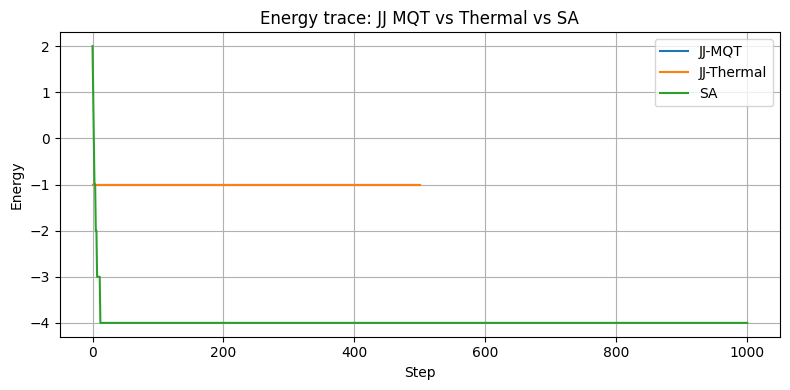

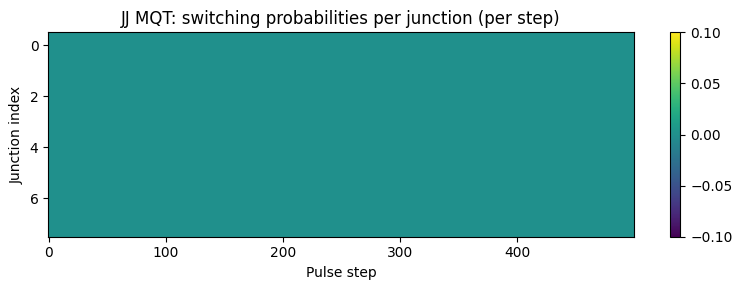

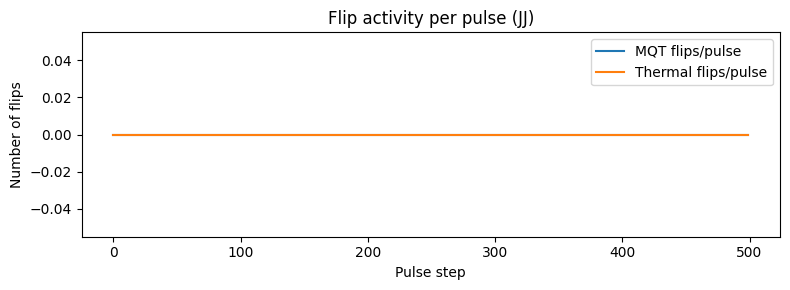

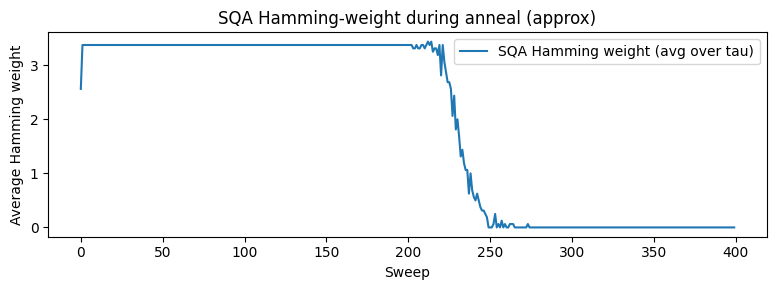

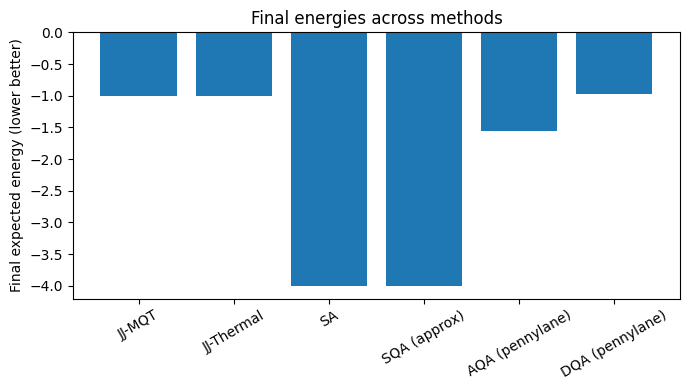

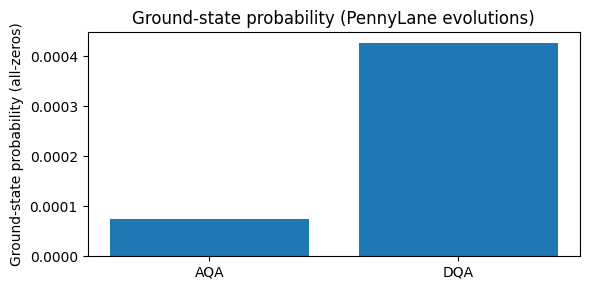

In [ ]:
#!/usr/bin/env python3
"""
jj_quantum_integration.py

Integrated simulation:
- Josephson-junction array (MQT vs Thermal) pulse-step Monte Carlo
- Ising mapping (Max-Cut & PHWO Fixed Plateau)
- PennyLane quantum annealing: Adiabatic (AQA) and Diabatic (DQA) using Hamiltonian time evolution
- Simulated Quantum Annealing (SQA) via Suzuki-Trotter classical mapping (approximate)
- Simulated Annealing (SA) baseline and Spin Vector Dynamics (SVD)
- Visualizations: energy traces, flip heatmaps, tunneling probs, Hamming-weight traces


"""

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import time
import math
import copy

# Try to import PennyLane device lightning for speed; fall back to default.qubit
try:
    import pennylane as qml
    from pennylane import numpy as pnp
    qml.device  # ensure present
except Exception as e:
    raise RuntimeError("PennyLane is required. Install with `pip install pennylane`") from e

# -----------------------------
# JJ physics utilities (from your jj_physics)
# -----------------------------
h = 6.62607015e-34
hbar = 1.054571817e-34
e = 1.602176634e-19
phi0 = h / (2 * e)
kb = 1.380649e-23

DEFAULT_Ic = 1.0e-6
DEFAULT_C = 1.0e-12
DEFAULT_EJ = phi0 * DEFAULT_Ic / (2 * np.pi)


def omega_p(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C) -> float:
    i = float(i_reduced)
    i = np.clip(i, 0.0, 0.999999)
    return np.sqrt(2.0 * e * Ic / (hbar * C)) * (1.0 - i**2)**0.25


def delta_U(i_reduced: float, EJ: float = DEFAULT_EJ) -> float:
    i = float(i_reduced)
    i = np.clip(i, 0.0, 0.999999)
    return 2.0 * EJ * (np.sqrt(1.0 - i**2) - i * np.arccos(i))


def gamma_th(i_reduced: float, T: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
             EJ: float = DEFAULT_EJ) -> float:
    if T <= 0.0:
        return 0.0
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    exponent = - dU / (kb * T)
    if exponent < -700:
        return 0.0
    return (op / (2.0 * np.pi)) * np.exp(exponent)


def gamma_mqt(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
              EJ: float = DEFAULT_EJ, hbar_eff: float = hbar) -> float:
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    arg = 36.0 * dU / (5.0 * hbar_eff * op)
    if arg > 700:
        return 0.0
    factor = max(1e-300, (864.0 * dU) / (hbar_eff * op))
    pref = (op / (2.0 * np.pi)) * np.sqrt(factor)
    return pref * np.exp(-arg)


def P_switch(i_reduced: float, pulse_s: float, T: float = None,
             Ic: float = DEFAULT_Ic, C: float = DEFAULT_C, EJ: float = DEFAULT_EJ) -> float:
    if pulse_s <= 0.0:
        return 0.0
    gamma = gamma_mqt(i_reduced, Ic=Ic, C=C, EJ=EJ) if T is None else gamma_th(i_reduced, T, Ic=Ic, C=C, EJ=EJ)
    lam = gamma * pulse_s
    lam = float(np.clip(lam, 0.0, 50.0))
    return 1.0 - np.exp(-lam)


# -----------------------------
# Ising mapping (ising_map)
# -----------------------------
def graph_to_Ising_J(adj_matrix: np.ndarray) -> np.ndarray:
    A = np.array(adj_matrix, dtype=float)
    if A.shape[0] != A.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    J = -A.copy()
    np.fill_diagonal(J, 0.0)
    return J


def ising_energy(s: np.ndarray, J: np.ndarray, h: np.ndarray = None) -> float:
    s = np.array(s, dtype=float).reshape(-1)
    J = np.array(J, dtype=float)
    if h is None:
        h = np.zeros_like(s)
    return -0.5 * float(s @ J @ s) - float(np.dot(h, s))


def random_weighted_graph(N: int, p_edge: float = 0.3, w_scale: float = 1.0, seed: int = None):
    rng = np.random.default_rng(seed)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(i + 1, N):
            if rng.random() < p_edge:
                val = rng.uniform(0.5, 1.5) * w_scale
                A[i, j] = val
                A[j, i] = val
    return A


# Fixed Plateau PHWO generator (for benchmarking)
def fixed_plateau_cost_fn(n, l=3, u=8):
    def f(x_bits):
        hw = int(np.sum(x_bits))
        if l < hw < u:
            return u - 1
        else:
            return hw
    return f


# Convert classical cost f(x) (defined on bitstring x) to Ising J and h (approx)
# For demonstration we construct diagonal Hamiltonian coefficients by summing contributions.
def cost_function_to_Jh_from_enumeration(n, cost_fn):
    # enumerate 2^n states when n is small (n <= 16 recommended)
    Nstates = 1 << n
    # we want to find J,h such that E(x) = const + -0.5 s^T J s - h^T s approximately equals cost(x) for s in {+1,-1}
    # We'll build linear regression: for all x, features = pairwise products and single spins
    # Solve least squares for coefficients. This is approximate and for small n only.
    X = []
    y = []
    for xint in range(Nstates):
        bits = np.array(list(np.binary_repr(xint, width=n)), dtype=int)
        s = 2 * bits - 1  # map 0->-1,1->+1
        features = []
        # pairwise s_i s_j (i<j)
        for i in range(n):
            for j in range(i+1, n):
                features.append(s[i] * s[j])
        # linear terms s_i
        for i in range(n):
            features.append(s[i])
        X.append(features)
        y.append(cost_fn(bits))
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    # Solve linear least squares: X w = y
    w, *_ = np.linalg.lstsq(X, y, rcond=None)
    # unpack into J and h by mapping coefficients appropriately
    J = np.zeros((n, n), dtype=float)
    idx = 0
    for i in range(n):
        for j in range(i+1, n):
            J[i, j] = w[idx]
            J[j, i] = w[idx]
            idx += 1
    h = np.zeros(n)
    for i in range(n):
        h[i] = w[idx]
        idx += 1
    # The Ising energy E_ising(s) = -0.5 s^T J s - h^T s should approx equal cost(x)
    return J, h


# -----------------------------
# JJ-array pulse-step Monte Carlo (MQT vs Thermal)
# -----------------------------
def local_field_to_reduced_bias(h_eff, i0=0.5, alpha=0.45, beta=1.0):
    h_eff = np.array(h_eff, dtype=float)
    return np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.9999)


def jj_array_simulator(J, h=None, pulse_s=10e-6, T=None,
                       i0=0.5, alpha=0.45, beta_map=1.0,
                       n_steps=1000, seed=None, verbose=False):
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    # initial spins +/-1
    s = rng.choice([-1, 1], size=N)
    energies = [ising_energy(s, J, h)]
    flips_record = np.zeros(n_steps, dtype=int)
    tunneling_probs = np.zeros((n_steps, N))
    best_E = energies[0]
    best_s = s.copy()

    for t in range(n_steps):
        h_eff = J @ s + h
        i_reduced = local_field_to_reduced_bias(h_eff, i0=i0, alpha=alpha, beta=beta_map)
        # compute switch prob per junction
        P = np.array([P_switch(float(i_reduced[k]), pulse_s, T) for k in range(N)])
        tunneling_probs[t, :] = P
        rand = rng.random(size=N)
        flips = (rand < P)
        flips_record[t] = flips.sum()
        s[flips] *= -1
        E = ising_energy(s, J, h)
        energies.append(E)
        if E < best_E:
            best_E = E
            best_s = s.copy()
        if verbose and (t % max(1, n_steps // 10) == 0):
            print(f"JJ sim [{t}/{n_steps}] E={E:.3f} best={best_E:.3f} flips={flips_record[t]}")
    return {
        'energies': np.array(energies),
        'final_s': s.copy(),
        'best_E': best_E,
        'best_s': best_s,
        'flips_record': flips_record,
        'tunneling_probs': tunneling_probs
    }


# -----------------------------
# Simulated Annealing (classical)
# -----------------------------
def simulated_annealing(J, h=None, T_start=5.0, T_end=0.1, n_steps=1000, seed=None):
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    s = rng.choice([-1, 1], size=N)
    E = ising_energy(s, J, h)
    best_E = E
    best_s = s.copy()
    energies = [E]
    temps = np.linspace(T_start, T_end, n_steps)
    for t, T in enumerate(temps):
        i = rng.integers(0, N)
        s_new = s.copy()
        s_new[i] *= -1
        E_new = ising_energy(s_new, J, h)
        dE = E_new - E
        if dE < 0 or rng.random() < np.exp(-dE / (kb * max(T, 1e-300))):
            s = s_new
            E = E_new
        energies.append(E)
        if E < best_E:
            best_E = E
            best_s = s.copy()
    return {'energies': np.array(energies), 'final_s': s, 'best_E': best_E, 'best_s': best_s}


# -----------------------------
# Spin Vector Dynamics (SVD) - symmetric reduction
# -----------------------------
def spin_vector_dynamics_symmetric(n, cost_fn, tf=10.0, n_steps=1000):
    # Solve symmetric SVD ODEs for theta(s), phi(s) as in paper.
    # We'll integrate Euler-ish for simplicity.
    dt = tf / n_steps
    # initial angles correspond to uniform superposition: theta=pi/2, phi=0
    theta = np.pi / 2.0
    phi = 0.0

    def VsymSC(theta_val, phi_val, s):
        # uses the symmetric potential expression: sum_w f(w) * comb(n,w) sin^{2w}(theta/2) cos^{2(n-w)}(theta/2)
        total = 0.0
        for w in range(0, n + 1):
            x = np.zeros(n, dtype=int)
            # Vsym built from cost on Hamming weight w:
            # Evaluate f(w) by setting a sample bitstring with weight w
            bits = np.array([1] * w + [0] * (n - w))
            fval = cost_fn(bits)
            comb = math.comb(n, w)
            p = (math.sin(theta_val / 2.0) ** 2) ** w * (math.cos(theta_val / 2.0) ** 2) ** (n - w)
            total += fval * comb * p
        # driver part
        driver = (1.0 - s) * n / 2.0 * (1.0 - math.cos(phi) * math.sin(theta))
        return driver + s * total

    # Euler integration for symmetric eqns (coarse)
    thetas = []
    phis = []
    for step in range(n_steps):
        s = step / n_steps
        # numeric derivatives (small eps)
        eps = 1e-6
        dV_dtheta = (VsymSC(theta + eps, phi, s) - VsymSC(theta - eps, phi, s)) / (2 * eps)
        dV_dphi = (VsymSC(theta, phi + eps, s) - VsymSC(theta, phi - eps, s)) / (2 * eps)
        # equations (D13) approximate (rescale so updates stable)
        theta_dot = (2.0 / n) * (1.0 / math.sin(theta + 1e-9)) * dV_dphi
        phi_dot = -(2.0 / n) * (1.0 / math.sin(theta + 1e-9)) * dV_dtheta
        theta = theta + dt * theta_dot
        phi = phi + dt * phi_dot
        thetas.append(theta)
        phis.append(phi)
    return {'theta_trace': np.array(thetas), 'phi_trace': np.array(phis), 'theta_final': theta, 'phi_final': phi}


# -----------------------------
# Simulated Quantum Annealing (SQA) - Suzuki-Trotter classical mapping (approx)
# -----------------------------
def sqa_simulation(J, h=None, n_tau=16, beta=10.0, n_sweeps=500, seed=None):
    """
    Approximate SQA via classical Monte Carlo on a +1/-1 lattice of shape (n, n_tau)
    Hamiltonian: sum_tau H_problem(s_tau) - K sum_{i, tau} s_{i,tau} s_{i,tau+1}
    K is transverse-field induced coupling. We pick K = 0.5 * log(coth(beta*Gamma/n_tau))
    We'll implement a simple anneal where Gamma is decreased from gamma_init -> 0 along sweeps.
    This is an approximation but captures the idea of thermal relaxation after minimum gap.
    """
    rng = np.random.default_rng(seed)
    n = J.shape[0]
    if h is None:
        h = np.zeros(n)
    # initialize random spins on (n, n_tau)
    spins = rng.choice([-1, 1], size=(n, n_tau))
    # schedule gamma -> affects K
    gamma_init = 1.0
    gamma_final = 0.01
    energies_trace = []
    hamming_trace = []
    for sweep in range(n_sweeps):
        # linear schedule for gamma
        gamma = gamma_init + (gamma_final - gamma_init) * (sweep / max(1, n_sweeps - 1))
        # coupling K (standard mapping approx)
        # to avoid numerical issues we use K = 0.5 * np.log(np.cosh(2*beta*gamma/n_tau)) as a heuristic
        # (many variants exist in the literature; this is a practical choice)
        arg = max(1e-12, 2.0 * beta * gamma / n_tau)
        K = 0.5 * np.log(np.cosh(arg))
        # sweep over all Trotter slices and spins
        for tau in range(n_tau):
            for i in range(n):
                # compute delta E for flipping spin i,tau
                # problem energy part
                s_old = spins[i, tau]
                # local energy from J and h in slice tau
                s_slice = spins[:, tau]
                deltaE_problem = 0.0
                # energy change due to flipping spin i: ΔE = E_new - E_old
                deltaE_problem = 2.0 * s_old * (0.5 * (J[i, :] @ s_slice) + h[i])
                # coupling to neighbors in tau direction
                s_up = spins[i, (tau - 1) % n_tau]
                s_dn = spins[i, (tau + 1) % n_tau]
                deltaE_coupling = 2.0 * s_old * (-K * (s_up + s_dn))
                deltaE = deltaE_problem + deltaE_coupling
                # Metropolis at temperature T = 1/beta
                if deltaE <= 0 or rng.random() < np.exp(-beta * deltaE):
                    spins[i, tau] = -s_old
        # record approximate physical quantities: average problem energy across slices and avg Hamming weight
        energy_total = 0.0
        hw_total = 0.0
        for tau in range(n_tau):
            s_slice = spins[:, tau]
            energy_total += ising_energy(s_slice, J, h)
            hw_total += 0.5 * (n - np.sum(s_slice))  # bits (0/1) count
        energies_trace.append(energy_total / n_tau)
        hamming_trace.append(hw_total / n_tau)
    return {'energies_trace': np.array(energies_trace), 'hamming_trace': np.array(hamming_trace), 'final_spins': spins}


# -----------------------------
# PennyLane AQA & DQA (construct Hamiltonian and TimeEvolution)
# -----------------------------
def ising_to_pennylane_hamiltonian(J, h):
    """Build qml.Hamiltonian with correct wire-specified PauliZ ops."""
    coeffs = []
    ops = []
    n = J.shape[0]
    # pairwise terms
    for i in range(n):
        for j in range(i + 1, n):
            if abs(J[i, j]) > 1e-12:
                coeffs.append(-0.5 * J[i, j])  # choose sign so mapping aligns with ising_energy def
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    # local fields
    for i in range(n):
        if abs(h[i]) > 1e-12:
            coeffs.append(-h[i])
            ops.append(qml.PauliZ(i))
    # If ops is empty (rare), create zero Hamiltonian
    if len(ops) == 0:
        ops = [qml.Identity(0)]
        coeffs = [0.0]
    return qml.Hamiltonian(coeffs, ops)


def run_pennylane_anneal(J, h=None, tf=5.0, n_steps=100, mode='adiabatic', device_name='default.qubit', wires_limit=16):
    """
    Run Trotterized time evolution with PennyLane's ApproxTimeEvolution template.
    mode: 'adiabatic' (linear s) or 'diabatic' (fast sin^2 schedule)
    Note: default.qubit supports qml.templates.ApproxTimeEvolution for small circuits.
    """
    n = J.shape[0]
    if h is None:
        h = np.zeros(n)
    H_problem = ising_to_pennylane_hamiltonian(J, h)
    # choose device
    dev = qml.device(device_name, wires=n)

    @qml.qnode(dev)
    def anneal_circuit():
        # start in uniform superposition
        for i in range(n):
            qml.Hadamard(wires=i)
        # Trotterized evolution
        dt = tf / n_steps
        for step in range(n_steps):
            t = step * dt
            if mode == 'adiabatic':
                s = t / tf
            elif mode == 'diabatic':
                s = math.sin((math.pi / 2.0) * (t / tf)) ** 2
            else:
                raise ValueError("mode must be 'adiabatic' or 'diabatic'")
            # driver part: (1-s) * sum X_i  => implement as RX pulses
            # small-angle RX approximating evolution under X
            for i in range(n):
                qml.RX(2.0 * (1.0 - s) * dt, wires=i)
            # problem Hamiltonian evolution: exp(-i s H_problem dt)
            # use ApproxTimeEvolution for the Hamiltonian
            qml.templates.ApproxTimeEvolution(H_problem, s * dt, 1)
        # return final state probabilities (full) or expectation of H_problem
        probs = qml.probs(wires=range(n))
        return probs

    probs = anneal_circuit()
    # compute expected energy from probs (classical)
    energy = 0.0
    for idx, p in enumerate(probs):
        bits = np.array(list(np.binary_repr(idx, width=n)), dtype=int)
        s = 2 * bits - 1
        energy += p * ising_energy(s, J, h)
    # ground-state prob (all zeros)
    p_gs = float(probs[0])
    return {'probs': probs, 'energy': energy, 'p_gs': p_gs}


# -----------------------------
# Helper: plotting utilities
# -----------------------------
def plot_energy_traces(traces, labels, title="Energy trace", xlabel="Step", ylabel="Energy"):
    plt.figure(figsize=(8, 4))
    for tr, lab in zip(traces, labels):
        plt.plot(tr, label=lab)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()


def plot_heatmap(matrix, title="Heatmap", xlabel="Time", ylabel="Junction"):
    plt.figure(figsize=(8, 3))
    plt.imshow(matrix.T, aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()


# -----------------------------
# Main demo experiment
# -----------------------------
def example_experiment(n=8, problem='fixed_plateau'):
    """
    Runs an integrated experiment:
    - builds problem (PHWO fixed plateau)
    - maps to J,h via enumeration (small n)
    - runs: JJ-array MQT (T=None), JJ-array Thermal (T>0), SA, SQA, AQA, DQA, SVD
    - plots summary and saves figures
    """
    assert n <= 12, "n recommended <= 12 for enumeration-based mapping and PennyLane default.qubit"
    print(f"Running integrated experiment for n={n}")

    # Build cost function
    if problem == 'fixed_plateau':
        cost_fn = fixed_plateau_cost_fn(n, l=2, u=4)  # choose small plateau for small n
    else:
        # default: random Max-Cut
        A = random_weighted_graph(n, p_edge=0.25, w_scale=1.0, seed=123)
        J = graph_to_Ising_J(A)
        cost_fn = None

    if problem == 'fixed_plateau':
        # map cost function to J,h by least-squares enumeration (approx.)
        J, h = cost_function_to_Jh_from_enumeration(n, cost_fn)
    else:
        # assume J constructed above
        J = J
        h = np.zeros(n)

    print("Problem mapped to J,h (approx).")

    # JJ-array MQT (quantum tunneling dominated)
    start = time.time()
    res_mqt = jj_array_simulator(J, h=h, pulse_s=10e-6, T=None,
                                n_steps=500, seed=1, verbose=False)
    t_mqt = time.time() - start
    print(f"JJ MQT run done in {t_mqt:.2f}s, best E = {res_mqt['best_E']:.4f}")

    # JJ-array Thermal (classical thermal escapes)
    start = time.time()
    res_th = jj_array_simulator(J, h=h, pulse_s=10e-6, T=0.05,  # 50 mK typical
                                n_steps=500, seed=1, verbose=False)
    t_th = time.time() - start
    print(f"JJ Thermal run done in {t_th:.2f}s, best E = {res_th['best_E']:.4f}")

    # Simulated Annealing baseline
    start = time.time()
    res_sa = simulated_annealing(J, h=h, T_start=5.0, T_end=0.01, n_steps=1000, seed=2)
    t_sa = time.time() - start
    print(f"SA done in {t_sa:.2f}s, best E = {res_sa['best_E']:.4f}")

    # SQA
    start = time.time()
    res_sqa = sqa_simulation(J, h=h, n_tau=16, beta=20.0, n_sweeps=400, seed=3)
    t_sqa = time.time() - start
    print(f"SQA (approx) done in {t_sqa:.2f}s, final energy (approx) = {res_sqa['energies_trace'][-1]:.4f}")

    # PennyLane quantum annealing (AQA)
    start = time.time()
    res_aqa = run_pennylane_anneal(J, h=h, tf=2.5, n_steps=80, mode='adiabatic', device_name='default.qubit')
    t_aqa = time.time() - start
    print(f"AQA done in {t_aqa:.2f}s, energy = {res_aqa['energy']:.4f}, p_gs = {res_aqa['p_gs']:.6f}")

    # PennyLane quantum annealing (DQA diabatic)
    start = time.time()
    res_dqa = run_pennylane_anneal(J, h=h, tf=2.5, n_steps=80, mode='diabatic', device_name='default.qubit')
    t_dqa = time.time() - start
    print(f"DQA done in {t_dqa:.2f}s, energy = {res_dqa['energy']:.4f}, p_gs = {res_dqa['p_gs']:.6f}")

    # SVD (symmetric)
    res_svd = spin_vector_dynamics_symmetric(n, cost_fn if cost_fn is not None else (lambda b: ising_energy(2*b-1, J, h)),
                                             tf=2.5, n_steps=800)
    print(f"SVD done, final theta = {res_svd['theta_final']:.4f}")

    # -----------------------------
    # Plots
    # -----------------------------
    # Energy traces for JJ MQT and Thermal (we'll align lengths)
    plot_energy_traces([res_mqt['energies'], res_th['energies'], res_sa['energies']],
                       ['JJ-MQT', 'JJ-Thermal', 'SA'], title="Energy trace: JJ MQT vs Thermal vs SA")

    # Flip activity heatmap (JJ MQT)
    plot_heatmap(res_mqt['tunneling_probs'], title="JJ MQT: switching probabilities per junction (per step)", xlabel="Pulse step", ylabel="Junction index")

    # Flips per pulse comparison
    plt.figure(figsize=(8, 3))
    plt.plot(res_mqt['flips_record'], label='MQT flips/pulse')
    plt.plot(res_th['flips_record'], label='Thermal flips/pulse')
    plt.xlabel('Pulse step')
    plt.ylabel('Number of flips')
    plt.title('Flip activity per pulse (JJ)')
    plt.legend()
    plt.tight_layout()

    # SQA Hamming-weight trace
    plt.figure(figsize=(8, 3))
    plt.plot(res_sqa['hamming_trace'], label='SQA Hamming weight (avg over tau)')
    plt.xlabel('Sweep')
    plt.ylabel('Average Hamming weight')
    plt.title('SQA Hamming-weight during anneal (approx)')
    plt.legend()
    plt.tight_layout()

    # Compare final energies / p_gs
    plt.figure(figsize=(7, 4))
    methods = ['JJ-MQT', 'JJ-Thermal', 'SA', 'SQA (approx)', 'AQA (pennylane)', 'DQA (pennylane)']
    values = [res_mqt['energies'][-1], res_th['energies'][-1], res_sa['energies'][-1], res_sqa['energies_trace'][-1], res_aqa['energy'], res_dqa['energy']]
    plt.bar(methods, values)
    plt.ylabel('Final expected energy (lower better)')
    plt.title('Final energies across methods')
    plt.xticks(rotation=30)
    plt.tight_layout()

    # p_gs bar for quantum methods (AQA/DQA) and JJ (approx via final spin)
    p_gs_vals = [None, None, None, None, res_aqa['p_gs'], res_dqa['p_gs']]
    plt.figure(figsize=(6, 3))
    plt.bar(['AQA', 'DQA'], [res_aqa['p_gs'], res_dqa['p_gs']])
    plt.ylabel('Ground-state probability (all-zeros)')
    plt.title('Ground-state probability (PennyLane evolutions)')
    plt.tight_layout()

    plt.show()

    return {
        'J': J, 'h': h,
        'res_mqt': res_mqt, 'res_th': res_th, 'res_sa': res_sa,
        'res_sqa': res_sqa, 'res_aqa': res_aqa, 'res_dqa': res_dqa, 'res_svd': res_svd
    }


if __name__ == "__main__":
    # run demo with n=8 (adjustable)
    out = example_experiment(n=8, problem='fixed_plateau')
